# 프로젝트 목표
고령화 사회 문제 중 가장 심각한 노인의 고독사를 데이터 문제로 풀기 위해 도시의 독거노인 수를 예측할 수 있는 모형을 설계

### DATA SET (2012년 , 서울시 동별 자료)
- 출처 : 서울 열린데이터 광장 (http://data.seoul.go.kr/)
- Y(target)  : 독거노인 수
- X(feature) : 장애인, 화재 발생 건수, 은행 지점, 노인 복지시설, 전입인구, 전출인구

In [87]:
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from pandas.io.pytables import IndexCol
from pandas.core.frame import DataFrame
from requests.api import head
from sklearn import svm
from numpy import newaxis
from pip.req.req_file import preprocess
from mistune import preprocessing
from sklearn.linear_model.base import LinearRegression
sns.set()
# sns.set_palette('pastel')

%cd ..

In [88]:
data = pd.read_csv('raw_data_number.csv', header=0, encoding='cp949')
print(data.tail())


        code   gu  dong  disable  fire  bank  seniorcenter  movingin  \
418  강동구둔촌1동  강동구  둔촌1동      455    10     2             8      2849   
419  강동구둔촌2동  강동구  둔촌2동     1003    13     7             5      4076   
420  강동구암사1동  강동구  암사1동     1617    15     4             3      6099   
421  강동구천호2동  강동구  천호2동     1847    29     7            13      5960   
422    강동구길동  강동구    길동     1950    37     9            15      7373   

     movingout  older  older2013  
418       3050    665        727  
419       4385    453        502  
420       6374    821        880  
421       6265    186        199  
422       7939    508        547  


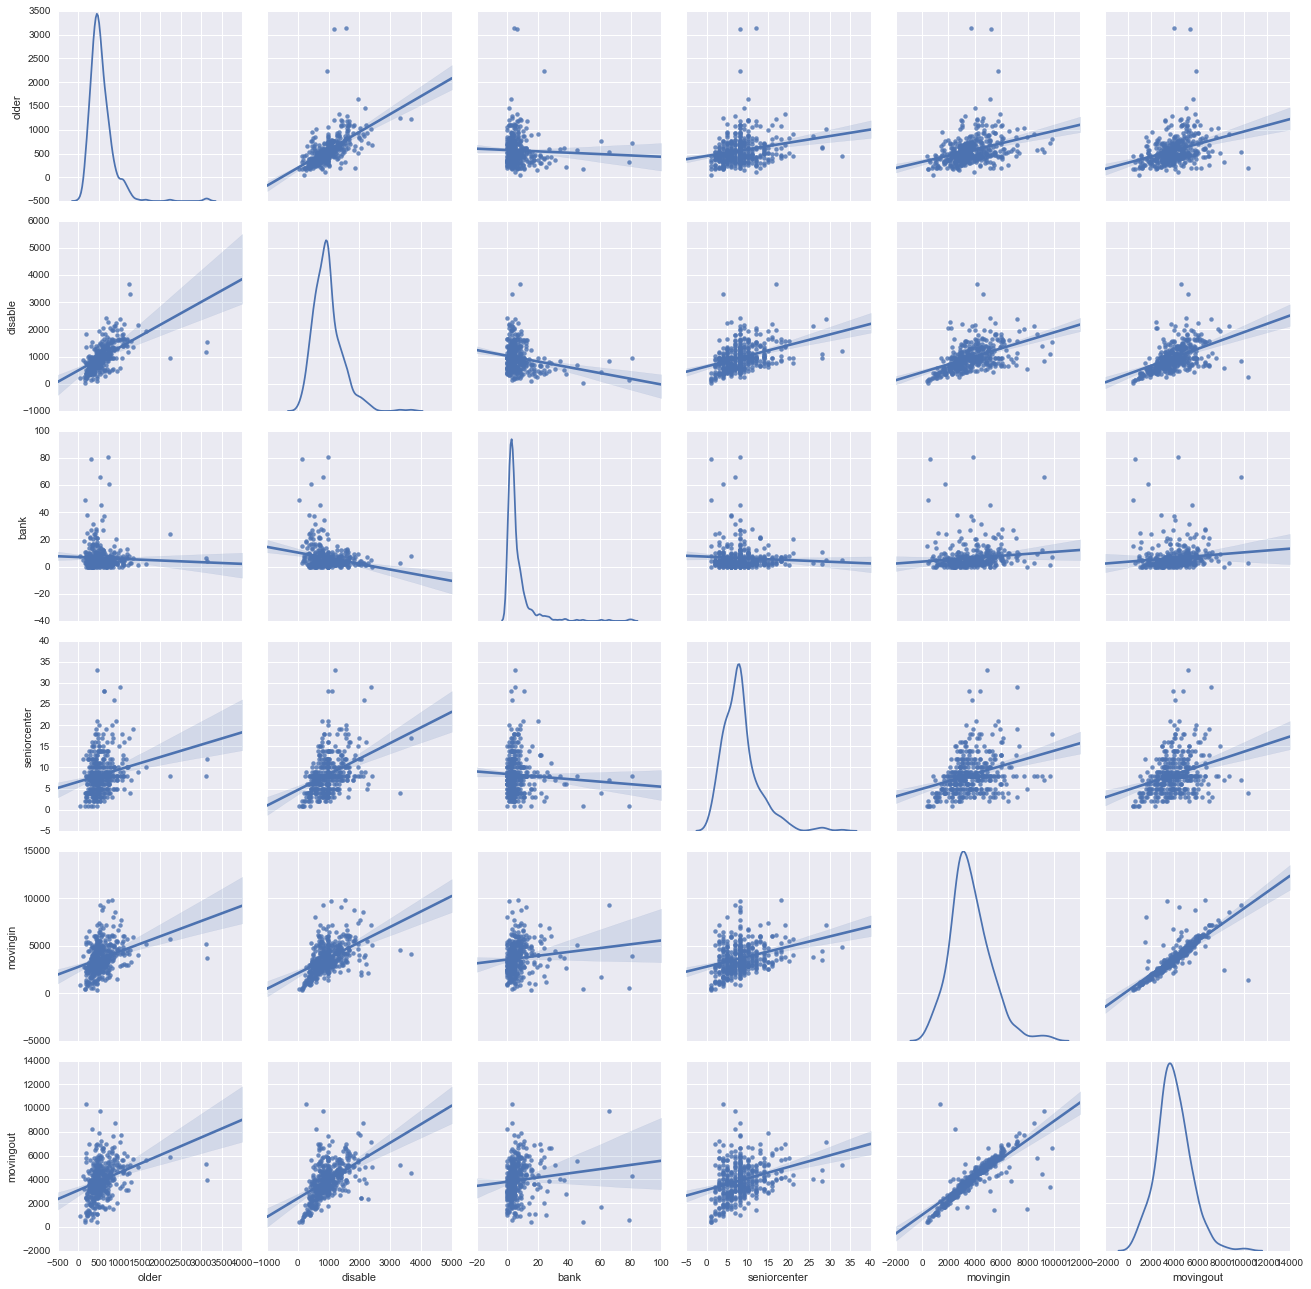

In [89]:
# 눈으로 자료의 관계성 확인
# 질문? plt 조절
sns.pairplot(data, diag_kind="kde", kind="reg" ,vars = ['older', 'disable', 'bank', 'seniorcenter', 'movingin', 'movingout'], size=3)
plt.show()

x,y 정해주기

In [90]:
y = data['older']
y2 = data['older2013']
x = data.drop(labels = ['code', 'gu', 'dong', 'older', 'older2013'], axis=1)

               disable      fire      bank  seniorcenter  movingin  movingout  \
disable       1.000000  0.185589 -0.209666      0.380607  0.488196   0.489488   
fire          0.185589  1.000000  0.489940      0.075529  0.411065   0.429240   
bank         -0.209666  0.489940  1.000000     -0.061527  0.119592   0.109945   
seniorcenter  0.380607  0.075529 -0.061527      1.000000  0.308768   0.295052   
movingin      0.488196  0.411065  0.119592      0.308768  1.000000   0.824094   
movingout     0.489488  0.429240  0.109945      0.295052  0.824094   1.000000   
older         0.562763  0.251880 -0.042128      0.201830  0.323813   0.311607   
older2013     0.748737  0.287850 -0.075903      0.293232  0.405319   0.414577   

                 older  older2013  
disable       0.562763   0.748737  
fire          0.251880   0.287850  
bank         -0.042128  -0.075903  
seniorcenter  0.201830   0.293232  
movingin      0.323813   0.405319  
movingout     0.311607   0.414577  
older         1.00

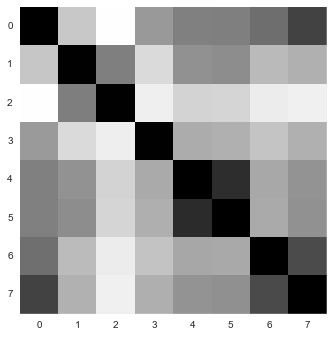

In [91]:
# correlation 확인
print(data.corr())
plt.imshow(data.corr(), interpolation="none")
plt.grid(False)
plt.show()

In [92]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
x_scale = pd.DataFrame(scale(x), index = x.index, columns = x.columns)
x_scale_norm = pd.DataFrame(normalize(x_scale), columns = x.columns)

In [93]:
x_scale_norm.tail()

,disable,fire,bank,seniorcenter,movingin,movingout
418,-0.733824,-0.281364,-0.312013,-0.039266,-0.358154,-0.393915
419,0.098034,-0.075450,0.089695,-0.862092,0.307550,0.372642
420,0.477991,0.059537,-0.085044,-0.397464,0.533508,0.564038
421,0.530854,0.515050,0.021055,0.293519,0.412907,0.442526
422,0.402863,0.531028,0.055482,0.283710,0.454244,0.515562


      disable      fire      bank  seniorcenter  movingin  movingout  older
418 -0.733824 -0.281364 -0.312013     -0.039266 -0.358154  -0.393915    665
419  0.098034 -0.075450  0.089695     -0.862092  0.307550   0.372642    453
420  0.477991  0.059537 -0.085044     -0.397464  0.533508   0.564038    821
421  0.530854  0.515050  0.021055      0.293519  0.412907   0.442526    186
422  0.402863  0.531028  0.055482      0.283710  0.454244   0.515562    508


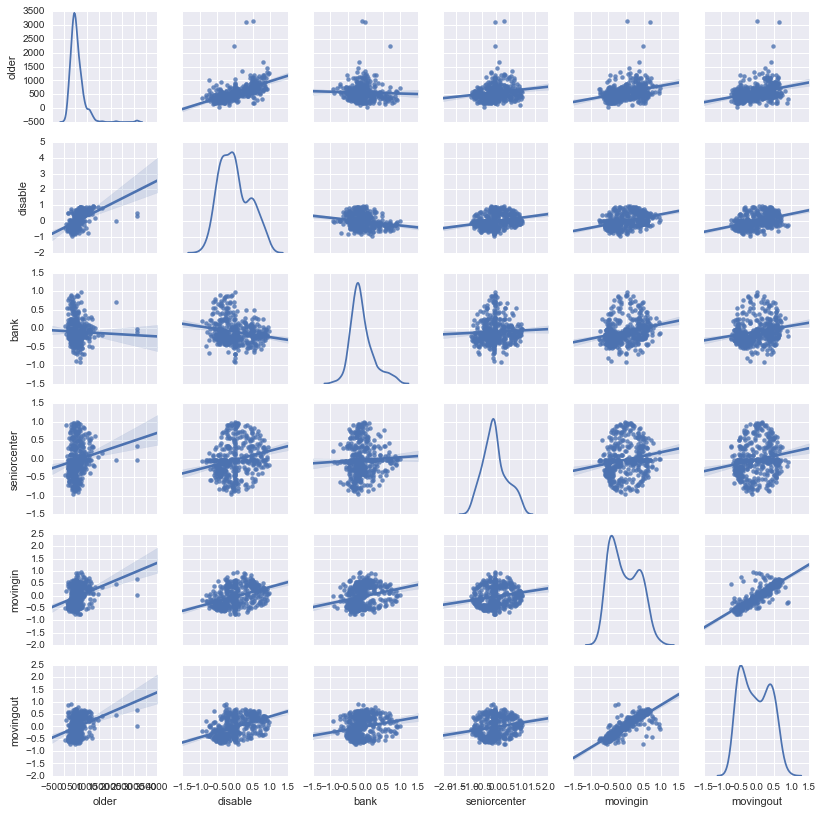

In [94]:
#scaling => normalize 된 것의 pairplot을 위해 잠시 y를 붙인 x_test를 만듦
x_test = pd.concat([x_scale_norm, y], axis=1)
print(x_test.tail())
sns.pairplot(x_test, diag_kind="kde", kind="reg" ,vars = ['older', 'disable', 'bank', 'seniorcenter', 'movingin', 'movingout'], size=1.9)
plt.show()

In [95]:
import statsmodels.api as sm

In [96]:
model_OLS = sm.OLS(y,x_scale_norm) 
result_OLS = model_OLS.fit()
print(result_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  older   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     9.597
Date:                Wed, 09 Mar 2016   Prob (F-statistic):           6.75e-10
Time:                        15:40:44   Log-Likelihood:                -3308.1
No. Observations:                 423   AIC:                             6628.
Df Residuals:                     417   BIC:                             6653.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
disable        261.7476     85.699      3.054   

In [97]:
# Intercept 추가

x_intercept = sm.add_constant(x_scale_norm)
model_OLS = sm.OLS(y,x_intercept) 
result_OLS = model_OLS.fit()
print(result_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  older   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     33.42
Date:                Wed, 09 Mar 2016   Prob (F-statistic):           6.86e-33
Time:                        15:40:44   Log-Likelihood:                -2942.4
No. Observations:                 423   AIC:                             5899.
Df Residuals:                     416   BIC:                             5927.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const          577.2075     13.143     43.917   

# OLS 모형 1차 해석
Adj. R-squared 값이 0.316로 낮긴하지만 F값의 p-value 값을 볼 때, 6.86e-33로 0에 가까우므로 모든 회귀계수가 0이라는 귀무가설을 기각하여 모형이 잘 만들어 졌다고 판단 내릴 수 있다. 독립변수들 하나하나를 살펴 볼 때 'bank', 'seniorcenter', 'movingin', 'movingout' 들은 T값의 p-value가 유의수준 0.05보다 커서 각 회귀계수가 0이라는 귀무가설을 기각하지 못한다. 의미는 회귀계수가 0이라서 그 값이 의미가 없음을 나타낸다.

Omnibus의 P-value 값과 Jarque-Bera (JB)의 p-value 값을 살펴 볼 때 유의 수준 0.05보다 크므로 정규분포라는 귀무가설을 기각하지 못함으로 이 데이터들은 정규분포의 가정을 만족한다고 할 수 있다.

# OLS 모형 개선

In [98]:
# P>|t| >0.05인 feature 제거

x_intercept = x_intercept.drop(labels = ['bank', 'movingout', 'seniorcenter', 'movingin'], axis=1)
x_scale_norm = x_scale_norm.drop(labels = ['bank', 'movingout', 'seniorcenter', 'movingin'], axis=1)

In [99]:
model_OLS = sm.OLS(y,x_intercept) 
result_OLS = model_OLS.fit()
print(result_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  older   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     99.82
Date:                Wed, 09 Mar 2016   Prob (F-statistic):           3.42e-36
Time:                        15:40:44   Log-Likelihood:                -2943.3
No. Observations:                 423   AIC:                             5893.
Df Residuals:                     420   BIC:                             5905.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        575.9826     12.628     45.613      0.0

# Outlier detection and removal

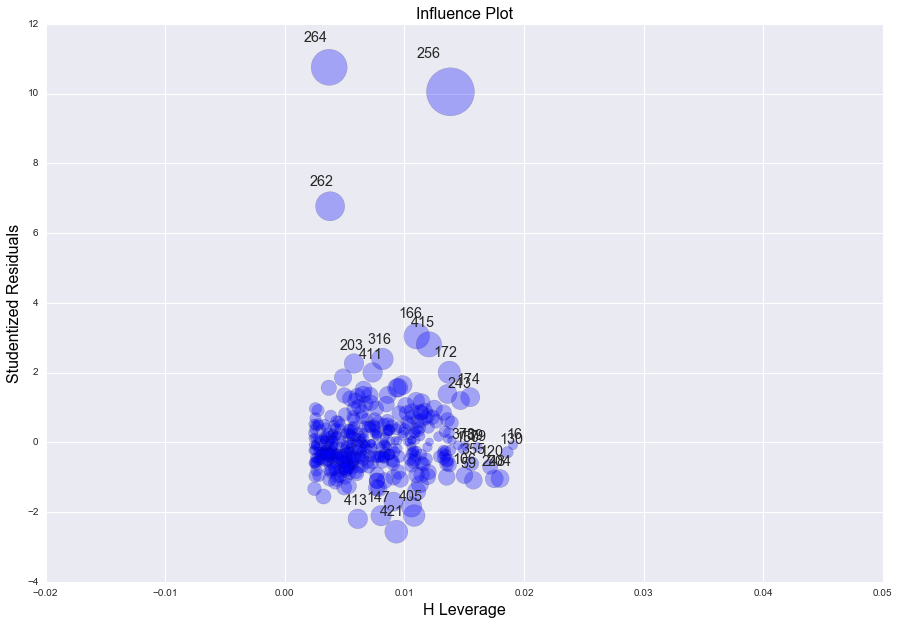

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
sm.graphics.influence_plot(result_OLS, plot_alpha=0.3, ax=ax)
plt.show()

(Outlier 제거는 feature selecting 이전에 해주어도 된다)

In [15]:
idx_outlier = np.nonzero(result_OLS.outlier_test().ix[:, -1].abs() < 0.01)[0]
idx_outlier

array([256, 262, 264])

In [16]:
print(data.ix[[264, 262, 256]])

        code   gu  dong  disable  fire  bank  seniorcenter  movingin  \
264  구로구구로5동  구로구  구로5동     1169    13     6             8      5218   
262  구로구구로3동  구로구  구로3동      944    19    24             8      5758   
256  강서구방화2동  강서구  방화2동     1548    30     4            12      3745   

     movingout  older  older2013  
264       5304   3115        870  
262       5872   2237        596  
256       3946   3146        954  


# Insight #1
- 아웃라이어(구로5동, 구로3동, 방화2동) 상위업종 10개를 조사해본 결과 택시업 종사자 비율이 높다

- 서울시의 428개 동중 방화2동, 구로3동이 각각 2,3위 이다

- 따라서, 독거노인과 택시업 연관관계가 있다고 추측된다

# Insight #2
- 노인복지센터는 현재 수요-공급 불균형이다


 # After outlier removal

In [17]:
#Outlier removal
x_intercept_out = x_intercept.drop(idx_outlier)
x_scale_norm_out = x_scale_norm.drop(idx_outlier)
y_out = y.drop(idx_outlier)

In [18]:
model_OLS_out = sm.OLS(y_out, x_intercept_out)
result_OLS_out = model_OLS_out.fit()
print(result_OLS_out.summary())

                            OLS Regression Results                            
Dep. Variable:                  older   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     171.8
Date:                Wed, 09 Mar 2016   Prob (F-statistic):           3.80e-55
Time:                        14:04:53   Log-Likelihood:                -2772.9
No. Observations:                 420   AIC:                             5552.
Df Residuals:                     417   BIC:                             5564.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        558.1731      8.886     62.812      0.0

# OLS 모형 2차 해석
무의미한 피처 제거와 아웃라이어에 해당하는 3개 샘플을 제거하여 모형을 개선할 수 있었다

# 모형 검증

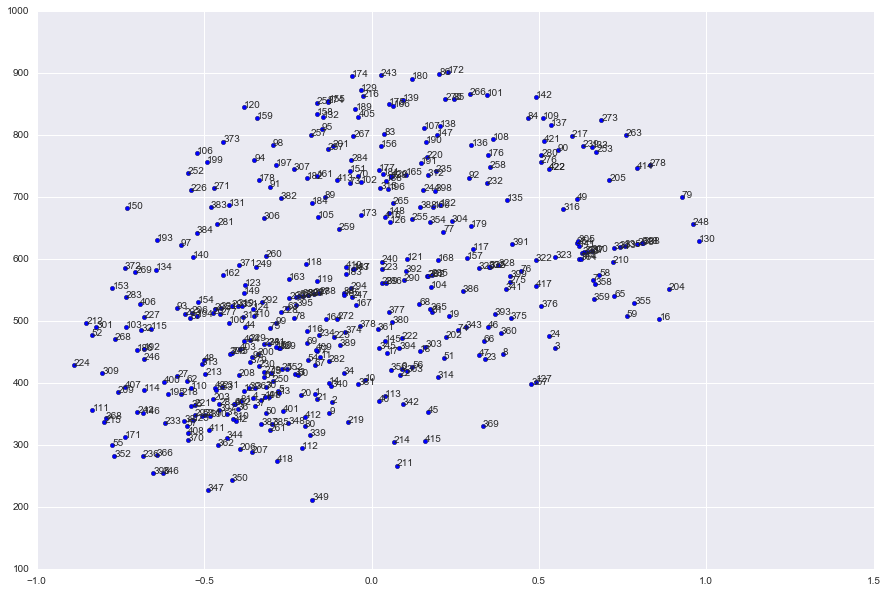

In [72]:
# 데이터 눈으로 확인하기
fig, ax = plt.subplots(figsize=(15, 10))

# http://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point
for i, txt in x_intercept_out.iterrows():
    ax.annotate(txt.name, (x_intercept_out['fire'][i],result_OLS_out.fittedvalues[i]))

plt.scatter(x_intercept_out['fire'], result_OLS_out.fittedvalues)
ax.annotate(txt.name, (x_intercept_out['fire'][i],result_OLS_out.fittedvalues[i]))
plt.show()

### 위 그래프에서 볼 수 있듯 [fire] feature 샘플중 눈에 띄게 선형성을 보이는 샘플들이 있어 별도로 조사해 보았으나 특이점을 찾을 수 없음


# Closs-validation(K-Fold) 

In [73]:
x_out = x.drop(idx_outlier)
y_out = y.drop(idx_outlier)
###size 420개 여야 한다
print(x_out.describe)
len(y_out)

<bound method DataFrame.describe of      disable  fire  bank  seniorcenter  movingin  movingout
0        358    16    24             2      1811       1979
1        134     8     3             2       452        548
2        367    11     2             4      1714       1827
3        611    22     5             5      2535       2685
4        326     4     1             4      1206       1254
5        426     7     2             2      1326       2189
6        204     1     6             4       780        926
7        436    61    61             4      1732       1677
8        310    25    14             4      1038       1055
9        346    11     6             6      1632       1877
10       350    13     5             3       948       1202
11       588    10     2             3      1161       1567
12       366     3     0             4      1022       1229
13       314     6     1             2      1162       1367
14       508    11     5             5      1633       1708
15  

420

In [74]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold


# Outlier 빼야한다 IndexError: positional indexers are out-of-bounds
# cross_val_score (model 의 하이퍼 파라매터를 넣어줘야한다)


print("r2_score : " , cross_val_score(LinearRegression(), x, y, "r2", KFold(len(x_scale_norm),4)))
print("mean_squared_error : " , cross_val_score(LinearRegression(), x, y, "mean_squared_error", KFold(len(x_scale_norm),4)))

r2_score :  [ 0.54158669  0.40308469  0.17239455 -0.41895846]
mean_squared_error :  [ -21469.9232131   -43008.38020119 -158215.61185306  -51277.88637187]


In [75]:
# print("r2_score : " , cross_val_score(LinearRegression(), x, y, "r2", KFold(len(x_scale_norm),4)))

# /Users/DS/anaconda/lib/python2.7/site-packages/pandas/core/indexing.pyc in _is_valid_list_like(self, key, axis)
#    1441         l = len(ax)
#    1442         if len(arr) and (arr.max() >= l or arr.min() < -l):
# -> 1443             raise IndexError("positional indexers are out-of-bounds")
#    1444 
#    1445         return True

# IndexError: positional indexers are out-of-bounds

# K-SVR(Kernel Support Vector Regression)

In [76]:
# SVR(Support Vector Regression), Radial Basis Function (RBF) kernel SVM #########################
print("\n ##Support Vector Regression Score##")
from sklearn.svm import SVR
svr_linear = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')
svr_sigmoid = SVR(kernel='sigmoid')
svr_rbf = SVR(kernel='rbf')

y2_out = y2.drop(idx_outlier)

score_l = svr_linear.fit(x_out, y_out).score(x_out ,y_out)
print("SVR_linear model(score)  : ", score_l)


 ##Support Vector Regression Score##
SVR_linear model(score)  :  0.484704058057


In [77]:
score_s = svr_sigmoid.fit(x_out, y_out).score(x_out ,y_out)
score_r = svr_rbf.fit(x_out, y_out).score(x_out ,y_out)

print("SVR_sigmoid model(score) : ", score_s)
print("SVR_rbf model(score)     : ", score_r)

SVR_sigmoid model(score) :  -0.0385204174347
SVR_rbf model(score)     :  -0.0320328319212


# 모델성능
OLS < Kernel SVR(kernel = linear)

In [78]:
# sigmoid는 계산이 매우 오래걸린다
# score_p = svr_poly.fit(x_out, y_out).score(x_out ,y_out)
# print("SVR_poly model(score)    : ", score_p)

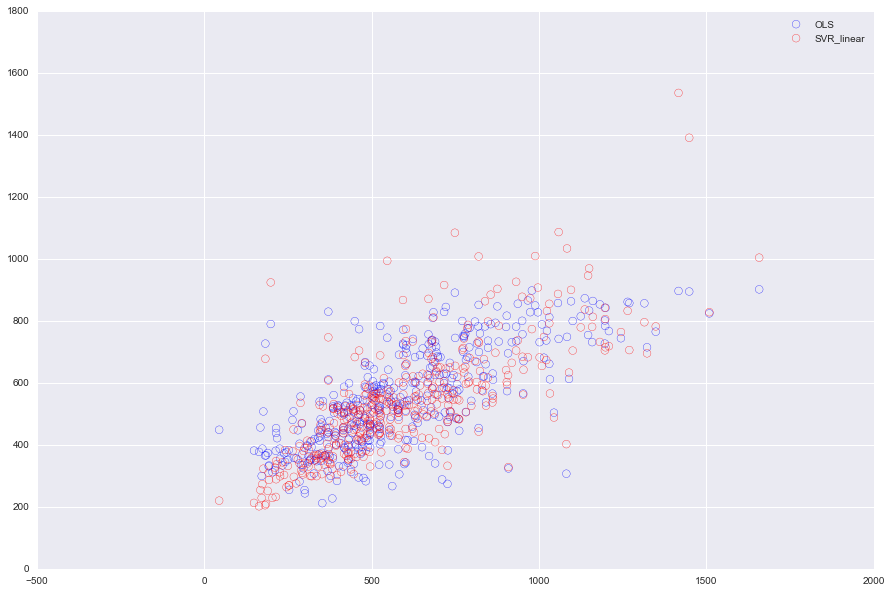

In [79]:
predictions_OLS = result_OLS_out.predict()
predictions_SVR = svr_linear.fit(x_out, y_out).predict(x_out)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(y2_out, predictions_OLS, marker='o', facecolors='none', edgecolors='b', s=60, label='OLS')
plt.scatter(y2_out, predictions_SVR, marker='o', facecolors='none', edgecolors='r', s=60, label='SVR_linear')
plt.legend()
plt.show()

# TEST

In [80]:
# sns.jointplot("older", "older2013", data=data, kind="reg", color="r", size=8)
# plt.show()

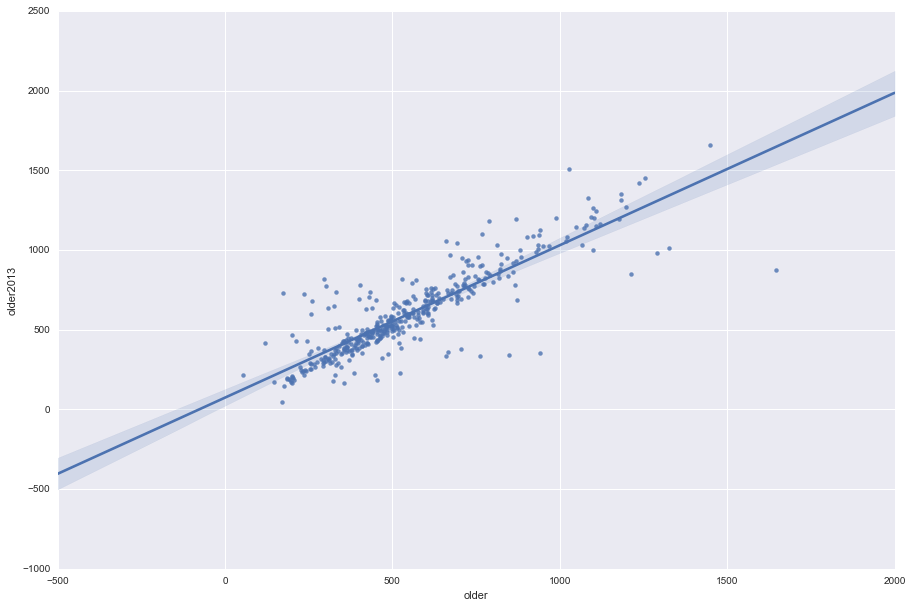

In [81]:
data_out = data.drop(idx_outlier)
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot("older", "older2013", data=data_out)
# Size of the confidence interval used when plotting a central tendency for discrete values of x. If “ci”, defer to the value of the``ci`` parameter.
plt.show()

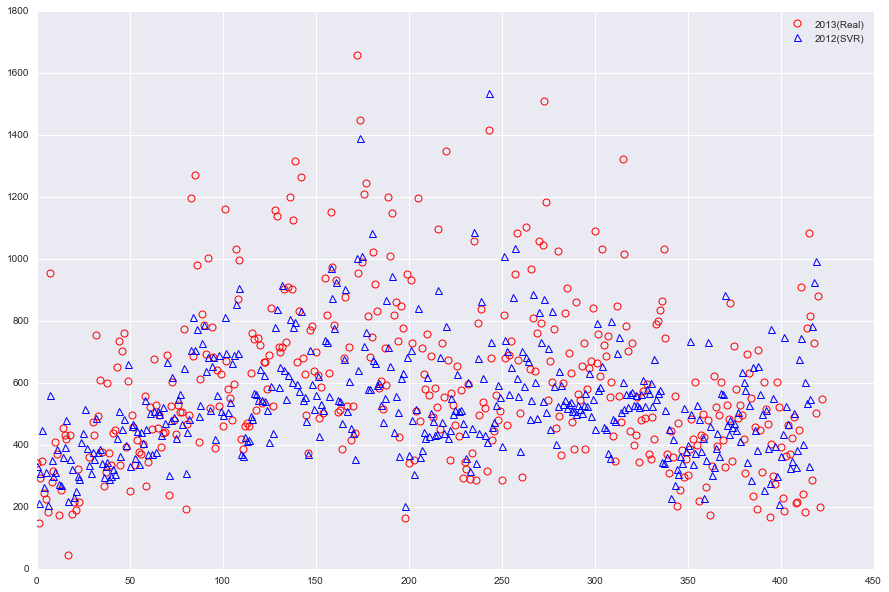

In [82]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(y2_out, 'o', markersize=7, markeredgewidth=1, markeredgecolor='r', markerfacecolor='None', label="2013(Real)")
plt.plot(predictions_SVR, 'r^', markersize=7, markeredgewidth=1, markeredgecolor='b', markerfacecolor='None', label="2012(SVR)")
plt.legend()
plt.show()

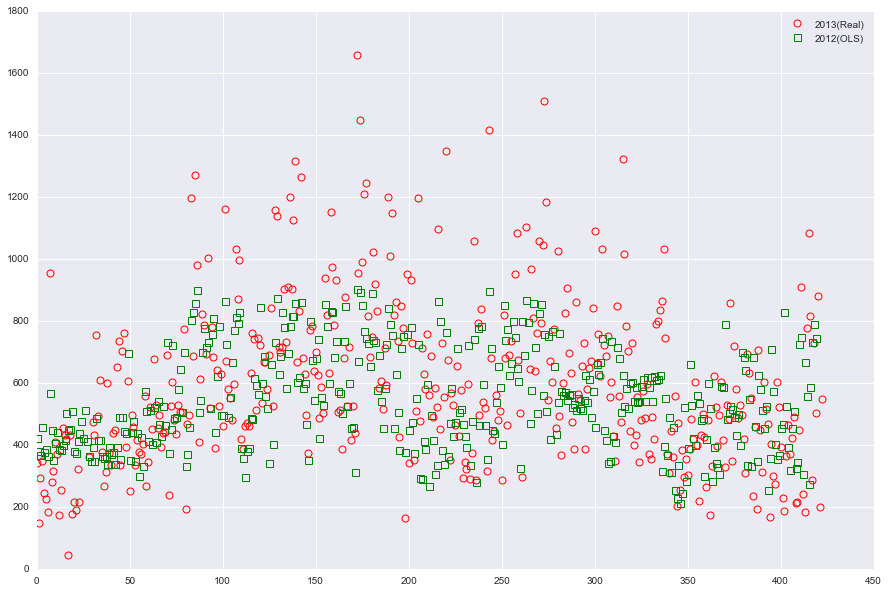

In [83]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(y2_out, 'o', markersize=7, markeredgewidth=1, markeredgecolor='r', markerfacecolor='None', label="2013(Real)")
plt.plot(predictions_OLS, 's', markersize=7, markeredgewidth=1, markeredgecolor='g', markerfacecolor='None', label="2012(OLS)")

plt.legend()
plt.show()

# 최종 결론
1. OLS모형 보다 Kernel SVR(kernel = linear)의 모형이 추정에 더 적합했다
2. 독거노인 수와 장애인 수, 화재 발생건수 들은 선형관계가 있다
3. 독거노인 수와 은행 수, 노인복지 시설 수, 전입 인구 수, 전출 인구 수는 선형관계에 있지않다


# Review
1.Model selection 을 수행하면 어떤 모형이 추천될것인가?
2.Regularization 을 수행하면 어떤 변화가 예상되는가?